In [189]:
import os 
import sys


from PIL import Image, ImageDraw
import numpy as np
import torch
from diffusers import AutoencoderKL, TCDScheduler
from diffusers.models.model_loading_utils import load_state_dict
from gradio_imageslider import ImageSlider
from huggingface_hub import hf_hub_download


In [3]:
# config_file = hf_hub_download(
#     "xinsir/controlnet-union-sdxl-1.0",
#     filename="config_promax.json",
# )

# config = ControlNetModel_Union.load_config(config_file)
# controlnet_model = ControlNetModel_Union.from_config(config)
# model_file = hf_hub_download(
#     "xinsir/controlnet-union-sdxl-1.0",
#     filename="diffusion_pytorch_model_promax.safetensors",
# )
# state_dict = load_state_dict(model_file)
# model, _, _, _, _ = ControlNetModel_Union._load_pretrained_model(
#     controlnet_model, state_dict, model_file, "xinsir/controlnet-union-sdxl-1.0"
# )
# model.to(device="cuda", dtype=torch.float16)


In [190]:

# vae = AutoencoderKL.from_pretrained(
#     "madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16
# ).to("cuda")

# pipe = StableDiffusionXLFillPipeline.from_pretrained(
#     "SG161222/RealVisXL_V5.0_Lightning",
#     torch_dtype=torch.float16,
#     vae=vae,
#     controlnet=model,
#     variant="fp16",
# ).to("cuda")

# pipe.scheduler = TCDScheduler.from_config(pipe.scheduler.config)

In [236]:
image = Image.open("/home/ubuntu/Varad/diffusion-extender/assets/man.jpeg").convert("RGB")
# image = Image.open("/home/ubuntu/Varad/diffusion-extender/assets/beach.jpg").convert("RGB")
image.size

(469, 612)

In [192]:
# image

In [208]:
def can_expand(source_width, source_height, target_width, target_height, alignment):
    """Checks if the image can be expanded based on the alignment."""
    if alignment in ("Left", "Right") and source_width >= target_width:
        return False
    if alignment in ("Top", "Bottom") and source_height >= target_height:
        return False
    return True

In [238]:
source = image
print(source.size)
target_size = ( 700, 700)
overlap = 42
alignment = "Middle"
if source.width < target_size[0] and source.height < target_size[1]:
        scale_factor = min(target_size[0] / source.width, target_size[1] / source.height)
        new_width = int(source.width * scale_factor)
        new_height = int(source.height * scale_factor)
        source = source.resize((new_width, new_height), Image.LANCZOS)

if source.width > target_size[0] or source.height > target_size[1]:
    scale_factor = min(target_size[0] / source.width, target_size[1] / source.height)
    new_width = int(source.width * scale_factor)
    new_height = int(source.height * scale_factor)
    source = source.resize((new_width, new_height), Image.LANCZOS)


resize_size = max(source.width, source.height)
aspect_ratio = source.height / source.width
new_width = resize_size
new_height = int(resize_size * aspect_ratio)
# source = source.resize((new_width, new_height), Image.LANCZOS)

if not can_expand(source.width, source.height, target_size[0], target_size[1], alignment):
    alignment = "Middle"

print(source.size[0])
print(source.size[1])


(469, 612)
536
700


In [239]:
if alignment == "Middle":
    print("Middle")
    print(target_size[0])
    print(target_size[1])
    print(source.width)
    print(source.height)
    margin_x = (target_size[0] - source.width) // 2
    margin_y = (target_size[1] - source.height) // 2
elif alignment == "Left":
    margin_x = 0
    margin_y = (target_size[1] - source.height) // 2
elif alignment == "Right":
    margin_x = target_size[0] - source.width
    margin_y = (target_size[1] - source.height) // 2
elif alignment == "Top":
    margin_x = (target_size[0] - source.width) // 2
    margin_y = 0
elif alignment == "Bottom":
    margin_x = (target_size[0] - source.width) // 2
    margin_y = target_size[1] - source.height

margin_x, margin_y




Middle
700
700
536
700


(82, 0)

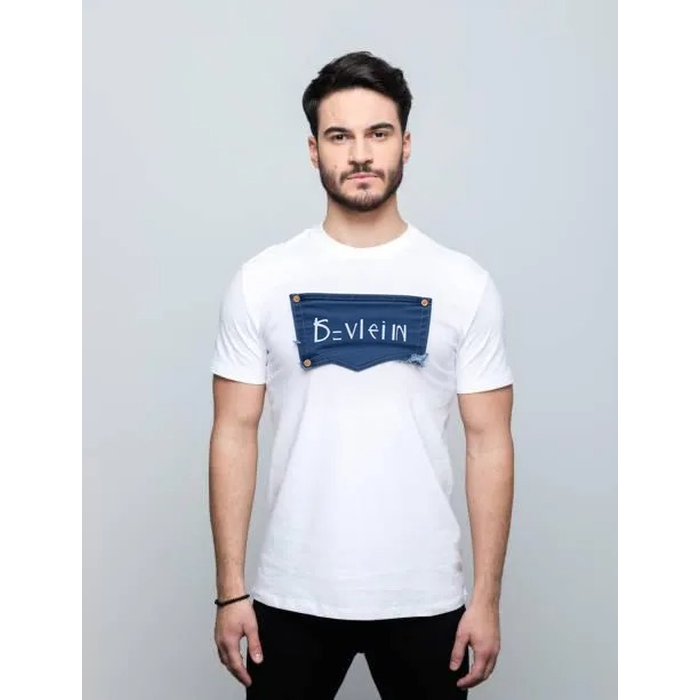

In [240]:
background = Image.new('RGB', target_size, (255, 255, 255))
background.paste(source, (margin_x, margin_y))
background



In [241]:
background.size

(700, 700)

In [242]:
mask = Image.new('L', target_size, 255)
mask_draw = ImageDraw.Draw(mask)
# overlap = 42
if alignment == "Middle":
        mask_draw.rectangle([
            (margin_x + overlap, margin_y + overlap),
            (margin_x + source.width - overlap, margin_y + source.height - overlap)
        ], fill=0)
mask.size



(700, 700)

In [214]:
# final_prompt = f"beach ,high quality, 4k"

# (
#         prompt_embeds,
#         negative_prompt_embeds,
#         pooled_prompt_embeds,
#         negative_pooled_prompt_embeds,
#     ) = pipe.encode_prompt(final_prompt, "cuda", True)

In [243]:
cnet_image = background.copy()
cnet_image.paste(0, (0, 0), mask)
cnet_image.size

(700, 700)

In [251]:
mask.size

(700, 700)

In [250]:
cnet_image.size

(700, 700)

In [15]:
# for image in pipe(
#         prompt_embeds=prompt_embeds,
#         negative_prompt_embeds=negative_prompt_embeds,
#         pooled_prompt_embeds=pooled_prompt_embeds,
#         negative_pooled_prompt_embeds=negative_pooled_prompt_embeds,
#         image=cnet_image,
#         num_inference_steps=10
#     ):
#         output_image = image

In [202]:
from io import BytesIO
import base64



In [246]:
def base64_to_img(img_str: str) -> Image.Image:
    return Image.open(BytesIO(base64.b64decode(img_str)))

def img_to_base64(img: Image.Image) -> str:
    buffered = BytesIO()
    img.save(buffered, format="JPEG")
    return base64.b64encode(buffered.getvalue()).decode()


In [257]:
import requests
import json
url = "http://0.0.0.0:8000/generate-image/"

print(mask.size)
mask.resize(700,700)
order_id = "94r804t8t-e830r8r48t"
c_net_base64 = img_to_base64(cnet_image)
mask_base64 = img_to_base64(mask)
num_inference_steps = 10
# prompt_input = "high quality, 4k , super resolution"
prompt_input = "high quality, 4k"
headers = {'Content-Type': 'application/json'}

payload = {
    "order_id": order_id,
    "c_net_base64": c_net_base64,
    "mask_base64": mask_base64,
    "num_inference_steps": num_inference_steps,
    "prompt_input": prompt_input
}

response = requests.post(url, json=payload, headers=headers)



(700, 700)


ValueError: Unknown resampling filter (700). Use Image.Resampling.NEAREST (0), Image.Resampling.LANCZOS (1), Image.Resampling.BILINEAR (2), Image.Resampling.BICUBIC (3), Image.Resampling.BOX (4) or Image.Resampling.HAMMING (5)

In [229]:
print(response.json())

{'message': 'success', 'status_code': 200, 'output_image': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAPoBQADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDklz1PSnduDTTgY75pRwOnWrJuK3J4PFJ2yaMDH86Xg8dqAuHSnZ70mcCk+oFAXAt16YxSDjpk0N7Umc44700JsUH1FNIJHt0oPTj9aAeOtOwC

In [230]:
output_image_b64 = response.json()["output_image"]
import io
import base64
output_image = Image.open(io.BytesIO(base64.b64decode(output_image_b64)))


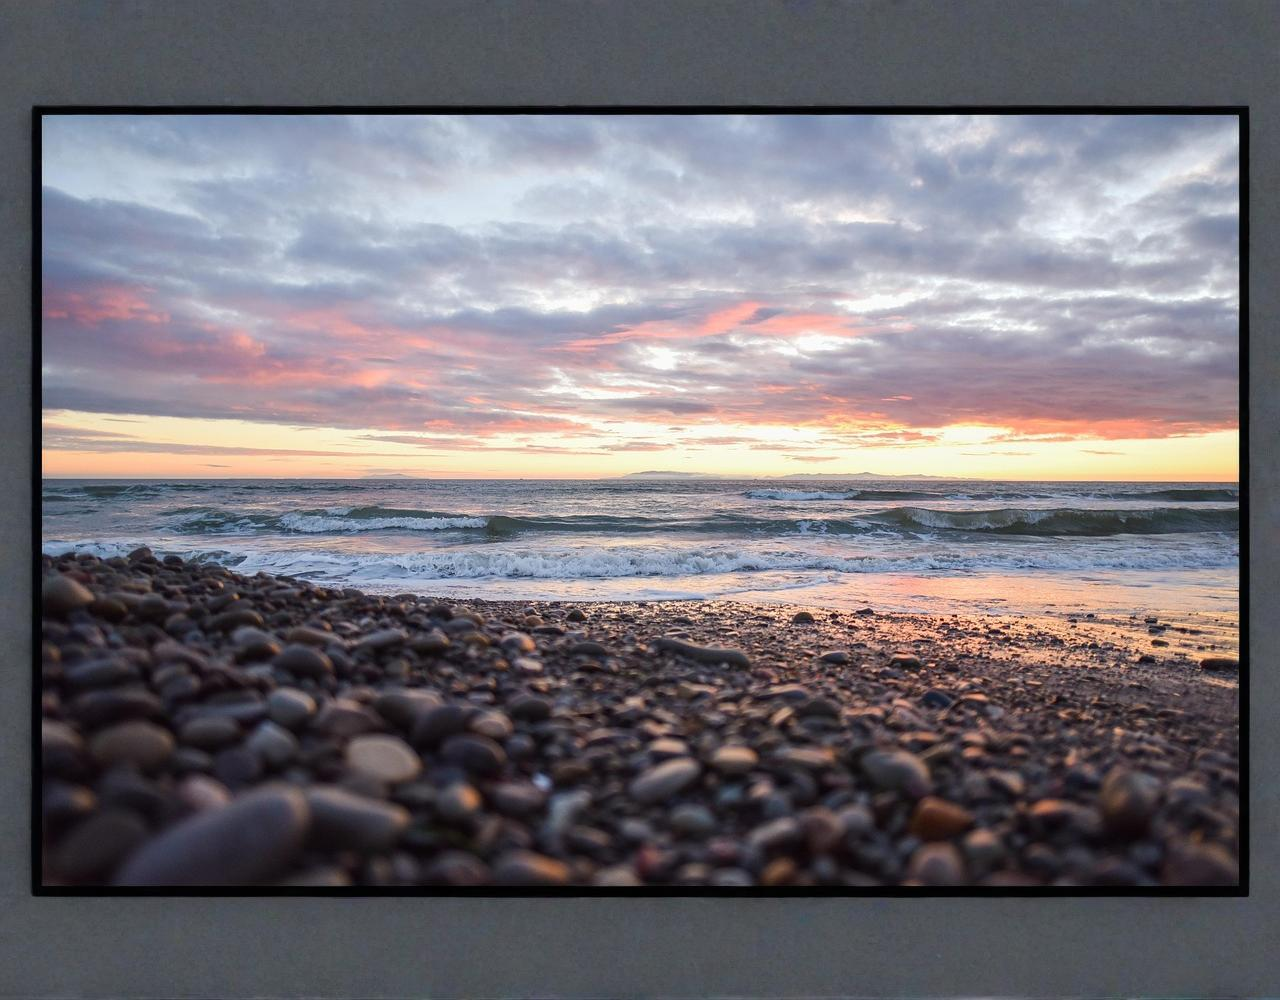

In [231]:
output_image

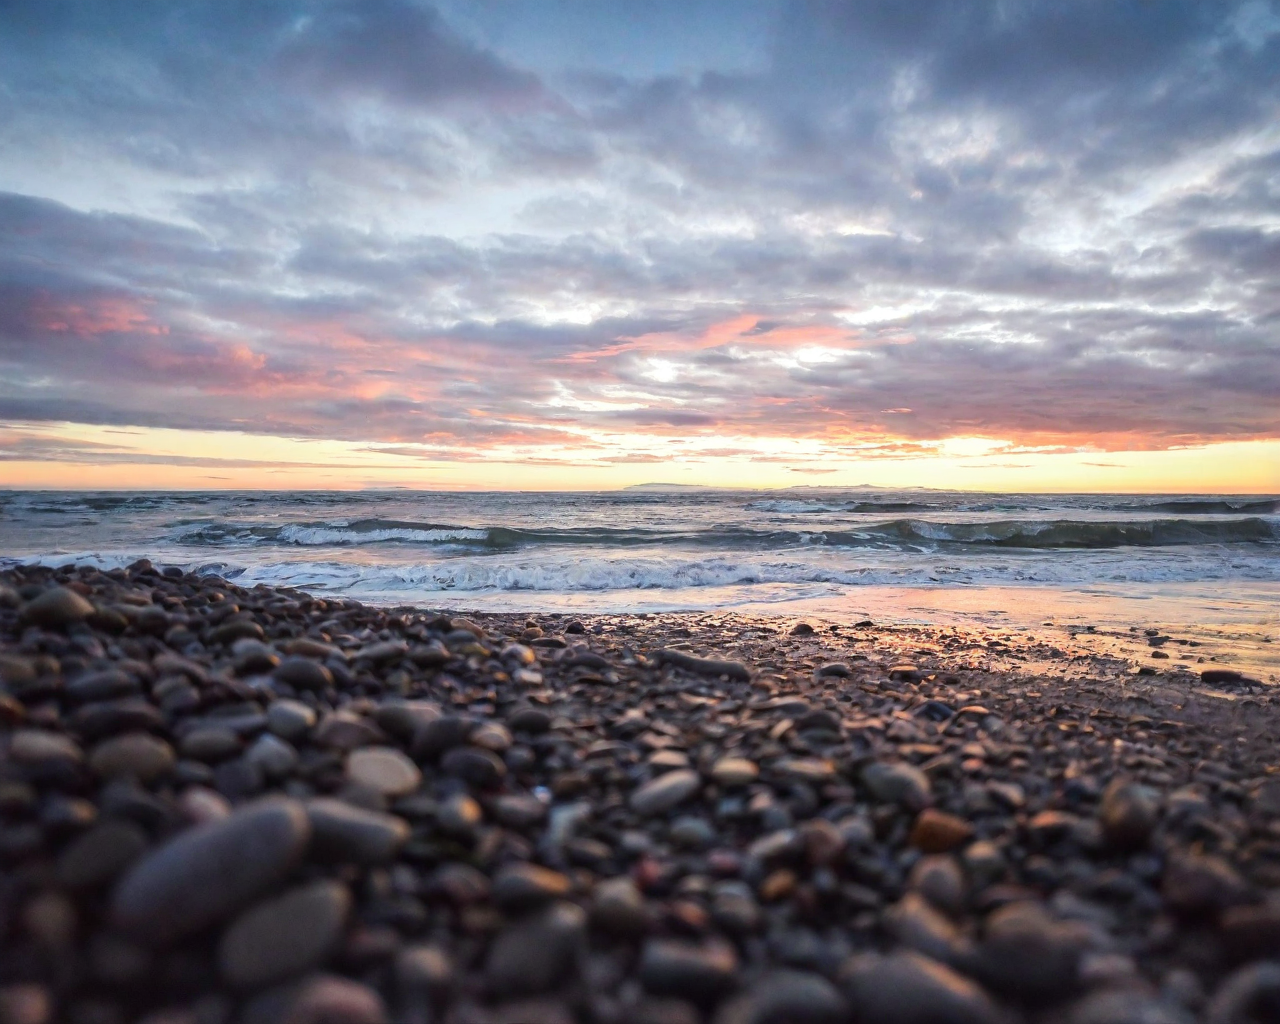

In [121]:
output_image